# Phase 3: Advanced Feature Engineering
## Intelligent Customer Segmentation & Revenue Optimization

---

### 📋 **Objective**
Create comprehensive behavioral, temporal, monetary, and engagement features to:
- Enhance clustering quality beyond basic RFM
- Enable predictive modeling (churn, CLV, next purchase)
- Generate actionable business insights

### 🎯 **Feature Categories**
1. **Behavioral Features**: Purchase patterns, basket characteristics
2. **Temporal Features**: Time-based patterns, seasonality
3. **Monetary Features**: Spending behavior, value metrics
4. **Engagement Features**: Activity consistency, churn risk

**Note**: Features are carefully organized to avoid duplication across categories

---

## 1. **Setup & Data Loading**

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [3]:
# Load datasets
path = "/home/cairo/code/portfolio/customer-segmentation/data/"
path_processed = "/home/cairo/code/portfolio/customer-segmentation/data/processed/"
path_reports = "/home/cairo/code/portfolio/customer-segmentation/outputs/reports/"
path_features = "/home/cairo/code/portfolio/customer-segmentation/data/features/"
path_campaigns = "/home/cairo/code/portfolio/customer-segmentation/outputs/campaigns/"
path_figures = "/home/cairo/code/portfolio/customer-segmentation/outputs/figures/"
path_models = "/home/cairo/code/portfolio/customer-segmentation/outputs/models/"

data = pd.read_csv(path_processed + 'data_cleaned.csv')
rfm_scores = pd.read_csv(path_processed + 'rfm_customer_scores.csv')

# Convert date columns
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print(f"📊 Data Shape: {data.shape}")
print(f"📊 RFM Scores Shape: {rfm_scores.shape}")
print(f"\n📅 Date Range: {data['InvoiceDate'].min()} to {data['InvoiceDate'].max()}")

📊 Data Shape: (805549, 15)
📊 RFM Scores Shape: (5878, 10)

📅 Date Range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00


## 2. **Data Preprocessing & Cleaning**

In [4]:
# Clean data for feature engineering
data_clean = data[data['Customer ID'].notna()].copy()

# Add TotalAmount column
data_clean['TotalAmount'] = data_clean['Quantity'] * data_clean['Price']

# Extract temporal features from InvoiceDate
data_clean['Year'] = data_clean['InvoiceDate'].dt.year
data_clean['Month'] = data_clean['InvoiceDate'].dt.month
data_clean['DayOfWeek'] = data_clean['InvoiceDate'].dt.dayofweek
data_clean['Hour'] = data_clean['InvoiceDate'].dt.hour
data_clean['IsWeekend'] = data_clean['DayOfWeek'].isin([5, 6]).astype(int)
data_clean['Quarter'] = data_clean['InvoiceDate'].dt.quarter

# Separate positive and negative transactions
positive_txns = data_clean[data_clean['Quantity'] > 0].copy()
negative_txns = data_clean[data_clean['Quantity'] < 0].copy()

# Reference date for recency calculations
reference_date = positive_txns['InvoiceDate'].max() + timedelta(days=1)

print(f"✅ Clean data shape: {data_clean.shape}")
print(f"✅ Positive transactions: {len(positive_txns):,}")
print(f"✅ Negative transactions (returns): {len(negative_txns):,}")
print(f"✅ Return rate: {len(negative_txns)/len(data_clean)*100:.2f}%")
print(f"📅 Reference Date: {reference_date.date()}")

✅ Clean data shape: (805549, 18)
✅ Positive transactions: 805,549
✅ Negative transactions (returns): 0
✅ Return rate: 0.00%
📅 Reference Date: 2011-12-10


## 3. **Comprehensive Feature Engineering**
### Creating all features in a single pass to avoid duplicates

In [5]:
# Calculate ALL features per customer in one loop
all_features = []

print("Engineering features for all customers...\n")

for idx, customer_id in enumerate(positive_txns['Customer ID'].unique()):
    if (idx + 1) % 1000 == 0:
        print(f"   Processed {idx+1:,} customers...")
    
    customer_data = positive_txns[positive_txns['Customer ID'] == customer_id]
    customer_returns = negative_txns[negative_txns['Customer ID'] == customer_id]
    
    # ========== BASIC METRICS ==========
    total_purchases = customer_data['Invoice'].nunique()
    total_items = customer_data['Quantity'].sum()
    total_revenue = customer_data['TotalAmount'].sum()
    first_purchase = customer_data['InvoiceDate'].min()
    last_purchase = customer_data['InvoiceDate'].max()
    purchase_dates = sorted(customer_data['InvoiceDate'].dt.date.unique())
    
    # ========== BEHAVIORAL FEATURES ==========
    avg_basket_size = total_items / total_purchases if total_purchases > 0 else 0
    avg_basket_value = total_revenue / total_purchases if total_purchases > 0 else 0
    avg_item_price = customer_data['Price'].mean()
    unique_products = customer_data['StockCode'].nunique()
    unique_categories = customer_data['Description'].nunique()
    product_diversity = unique_products / total_purchases if total_purchases > 0 else 0
    days_active = len(purchase_dates)
    
    # Inter-purchase time
    if len(purchase_dates) > 1:
        inter_purchase_days_list = [(purchase_dates[i+1] - purchase_dates[i]).days 
                                     for i in range(len(purchase_dates)-1)]
        avg_inter_purchase_days = np.mean(inter_purchase_days_list)
        std_inter_purchase_days = np.std(inter_purchase_days_list)
        max_inter_purchase_days = max(inter_purchase_days_list)
        min_inter_purchase_days = min(inter_purchase_days_list)
    else:
        avg_inter_purchase_days = 0
        std_inter_purchase_days = 0
        max_inter_purchase_days = 0
        min_inter_purchase_days = 0
    
    # Bulk buyer
    max_quantity = customer_data.groupby('Invoice')['Quantity'].sum().max()
    is_bulk_buyer = 1 if max_quantity > 100 else 0
    
    # ========== TEMPORAL FEATURES ==========
    hour_counts = customer_data['Hour'].value_counts()
    preferred_hour = hour_counts.idxmax() if len(hour_counts) > 0 else 12
    hour_concentration = hour_counts.max() / len(customer_data) if len(customer_data) > 0 else 0
    
    weekend_purchases = customer_data['IsWeekend'].sum()
    weekend_ratio = weekend_purchases / len(customer_data) if len(customer_data) > 0 else 0
    is_weekend_shopper = 1 if weekend_ratio > 0.5 else 0
    
    dow_counts = customer_data['DayOfWeek'].value_counts()
    preferred_day = dow_counts.idxmax() if len(dow_counts) > 0 else 0
    
    quarter_counts = customer_data['Quarter'].value_counts()
    preferred_quarter = quarter_counts.idxmax() if len(quarter_counts) > 0 else 1
    quarter_concentration = quarter_counts.max() / len(customer_data) if len(customer_data) > 0 else 0
    
    active_months = customer_data['InvoiceDate'].dt.to_period('M').nunique()
    customer_lifetime_days = (last_purchase - first_purchase).days
    purchase_velocity = (total_purchases / customer_lifetime_days) * 30 if customer_lifetime_days > 0 else 0
    
    # ========== MONETARY FEATURES ==========
    invoice_totals = customer_data.groupby('Invoice')['TotalAmount'].sum()
    aov = invoice_totals.mean()
    aov_std = invoice_totals.std()
    aov_max = invoice_totals.max()
    aov_min = invoice_totals.min()
    
    max_price = customer_data['Price'].max()
    min_price = customer_data['Price'].min()
    price_range = max_price - min_price
    price_std = customer_data['Price'].std()
    
    spending_cv = (invoice_totals.std() / invoice_totals.mean()) if invoice_totals.mean() > 0 else 0
    clv = total_revenue
    
    # Revenue growth (first half vs second half)
    if total_purchases >= 4:
        invoices_sorted = customer_data.sort_values('InvoiceDate')['Invoice'].unique()
        mid_point = len(invoices_sorted) // 2
        first_half = customer_data[customer_data['Invoice'].isin(invoices_sorted[:mid_point])]['TotalAmount'].sum()
        second_half = customer_data[customer_data['Invoice'].isin(invoices_sorted[mid_point:])]['TotalAmount'].sum()
        first_half_avg = first_half / mid_point if mid_point > 0 else 0
        second_half_avg = second_half / (len(invoices_sorted) - mid_point) if (len(invoices_sorted) - mid_point) > 0 else 0
        revenue_growth = ((second_half_avg - first_half_avg) / first_half_avg) * 100 if first_half_avg > 0 else 0
    else:
        revenue_growth = 0
    
    # Return behavior
    num_returns = len(customer_returns)
    return_value = abs(customer_returns['TotalAmount'].sum()) if len(customer_returns) > 0 else 0
    return_rate = num_returns / len(customer_data) if len(customer_data) > 0 else 0
    
    # ========== ENGAGEMENT FEATURES ==========
    days_since_last = (reference_date - last_purchase).days
    tenure_days = (reference_date - first_purchase).days
    activity_rate = (total_purchases / tenure_days) * 30 if tenure_days > 0 else 0
    
    total_months = max(1, (last_purchase - first_purchase).days / 30)
    engagement_consistency = active_months / total_months if total_months > 0 else 0
    
    # Expected next purchase
    if len(purchase_dates) > 1:
        expected_next_purchase = last_purchase + timedelta(days=avg_inter_purchase_days)
        days_overdue = (reference_date - expected_next_purchase).days
    else:
        days_overdue = 0
    
    # Churn risk score (0-100)
    recency_score = min(100, (days_since_last / 365) * 100)
    overdue_score = min(100, max(0, days_overdue / 180) * 100) if days_overdue > 0 else 0
    low_engagement_score = (1 - engagement_consistency) * 50
    churn_risk_score = (recency_score * 0.5 + overdue_score * 0.3 + low_engagement_score * 0.2)
    loyalty_index = 100 - churn_risk_score
    is_at_risk = 1 if churn_risk_score > 60 else 0
    
    # ========== COMPILE ALL FEATURES ==========
    all_features.append({
        # ID
        'CustomerID': customer_id,
        
        # BEHAVIORAL (10 features)
        'avg_basket_size': avg_basket_size,
        'avg_basket_value': avg_basket_value,
        'avg_item_price': avg_item_price,
        'unique_products': unique_products,
        'product_diversity': product_diversity,
        'days_active': days_active,
        'avg_inter_purchase_days': avg_inter_purchase_days,
        'std_inter_purchase_days': std_inter_purchase_days,
        'is_bulk_buyer': is_bulk_buyer,
        'max_quantity_single_txn': max_quantity,
        
        # TEMPORAL (10 features)
        'preferred_hour': preferred_hour,
        'hour_concentration': hour_concentration,
        'weekend_ratio': weekend_ratio,
        'is_weekend_shopper': is_weekend_shopper,
        'preferred_day': preferred_day,
        'preferred_quarter': preferred_quarter,
        'quarter_concentration': quarter_concentration,
        'active_months': active_months,
        'customer_lifetime_days': customer_lifetime_days,
        'purchase_velocity': purchase_velocity,
        
        # MONETARY (13 features)
        'total_revenue': total_revenue,
        'aov': aov,
        'aov_std': aov_std,
        'aov_max': aov_max,
        'aov_min': aov_min,
        'avg_price': avg_item_price,  # Same as behavioral but makes sense here too
        'max_price': max_price,
        'price_range': price_range,
        'spending_cv': spending_cv,
        'clv': clv,
        'revenue_growth': revenue_growth,
        'return_rate': return_rate,
        'return_value': return_value,
        
        # ENGAGEMENT (9 features)
        'days_since_last': days_since_last,
        'tenure_days': tenure_days,
        'activity_rate': activity_rate,
        'engagement_consistency': engagement_consistency,
        'days_overdue': days_overdue,
        'churn_risk_score': churn_risk_score,
        'loyalty_index': loyalty_index,
        'is_at_risk': is_at_risk,
        'purchase_frequency': total_purchases
    })

# Create DataFrame
features_engineered = pd.DataFrame(all_features)

print(f"\n✅ Feature engineering complete!")
print(f"📊 Total customers: {len(features_engineered):,}")
print(f"📊 Total features: {len(features_engineered.columns)} columns")
print(f"📊 Feature breakdown:")
print(f"   - Behavioral: 10 features")
print(f"   - Temporal: 10 features")
print(f"   - Monetary: 13 features")
print(f"   - Engagement: 9 features")
print(f"   - Total: 42 engineered features + CustomerID")

features_engineered.head(10)

Engineering features for all customers...

   Processed 1,000 customers...
   Processed 2,000 customers...
   Processed 3,000 customers...
   Processed 4,000 customers...
   Processed 5,000 customers...

✅ Feature engineering complete!
📊 Total customers: 5,878
📊 Total features: 43 columns
📊 Feature breakdown:
   - Behavioral: 10 features
   - Temporal: 10 features
   - Monetary: 13 features
   - Engagement: 9 features
   - Total: 42 engineered features + CustomerID


,CustomerID,avg_basket_size,avg_basket_value,avg_item_price,unique_products,product_diversity,days_active,avg_inter_purchase_days,std_inter_purchase_days,is_bulk_buyer,max_quantity_single_txn,preferred_hour,hour_concentration,weekend_ratio,is_weekend_shopper,preferred_day,preferred_quarter,quarter_concentration,active_months,customer_lifetime_days,purchase_velocity,total_revenue,aov,aov_std,aov_max,aov_min,avg_price,max_price,price_range,spending_cv,clv,revenue_growth,return_rate,return_value,days_since_last,tenure_days,activity_rate,engagement_consistency,days_overdue,churn_risk_score,loyalty_index,is_at_risk,purchase_frequency
0,13085.00,118.00,304.16,3.56,50,6.25,5,145.25,146.08,1,188,11,0.23,0.00,0,4,1,0.58,4,581,0.41,2433.28,304.16,153.58,505.30,137.98,3.56,8.50,7.95,0.50,2433.28,21.85,0.00,0,158,739,0.32,0.21,12,31.58,68.42,0,8
1,13078.00,213.74,518.11,3.89,153,2.68,55,13.61,6.51,1,552,9,0.18,0.11,0,2,4,0.35,25,735,2.33,29532.45,518.11,207.01,1028.78,100.80,3.89,12.75,12.56,0.40,29532.45,1.34,0.00,0,3,739,2.31,1.02,-10,0.21,99.79,0,57
2,15362.00,184.00,306.54,3.61,38,19.00,2,290.00,0.00,1,223,9,0.57,0.00,0,1,4,0.57,2,290,0.21,613.08,306.54,5.95,310.75,302.33,3.61,9.95,9.74,0.02,613.08,0.00,0.00,0,449,739,0.08,0.21,159,84.43,15.57,1,2
3,18102.00,1298.90,4198.77,3.90,382,2.63,67,11.18,10.68,1,7782,11,0.22,0.02,0,1,4,0.31,23,738,5.89,608821.65,4198.77,5458.55,31770.98,6.80,3.90,52.78,52.51,1.30,608821.65,36.51,0.00,0,1,739,5.89,0.93,-11,0.79,99.21,0,145
4,12682.00,211.88,462.19,3.59,327,6.29,48,15.64,10.60,1,688,13,0.20,0.04,0,1,4,0.35,25,735,2.12,24033.91,462.19,264.33,1478.10,18.00,3.59,18.00,17.79,0.57,24033.91,-36.03,0.00,0,4,739,2.11,1.02,-12,0.34,99.66,0,52
5,18087.00,457.35,868.32,12.75,44,2.59,14,49.23,51.30,1,3906,9,0.27,0.00,0,0,4,0.49,10,640,0.80,14761.52,868.32,1458.72,5737.32,50.40,12.75,852.80,852.44,1.68,14761.52,400.30,0.00,0,98,739,0.69,0.47,49,26.90,73.10,0,17
6,13635.00,471.00,749.79,2.29,135,33.75,4,223.67,153.04,1,730,10,0.75,0.00,0,0,4,0.63,3,671,0.18,2999.16,749.79,406.50,1130.98,382.37,2.29,11.95,11.56,0.54,2999.16,176.24,0.00,0,68,739,0.16,0.13,-156,17.97,82.03,0,4
7,14110.00,176.52,393.57,2.71,177,5.36,32,23.71,29.10,1,470,11,0.35,0.12,0,1,2,0.39,18,735,1.35,12987.95,393.57,199.50,904.26,41.60,2.71,9.95,9.74,0.51,12987.95,41.77,0.00,0,4,739,1.34,0.73,-20,3.20,96.80,0,33
8,12636.00,1.00,141.00,141.00,1,1.00,1,0.00,0.00,0,1,9,1.00,0.00,0,1,4,1.00,1,0,0.00,141.00,141.00,NaN,141.00,141.00,141.00,141.00,0.00,NaN,141.00,0.00,0.00,0,739,739,0.04,1.00,0,50.00,50.00,0,1
9,17519.00,227.60,340.63,3.56,142,9.47,15,51.50,30.65,1,368,10,0.20,0.10,0,3,4,0.32,15,721,0.62,5109.47,340.63,100.86,670.60,200.50,3.56,79.95,79.74,0.30,5109.47,7.66,0.00,0,17,739,0.61,0.62,-34,6.09,93.91,0,15


## 4. **Merge with RFM Scores**

In [6]:
# Merge engineered features with RFM scores
features_master = rfm_scores[['CustomerID', 'Recency', 'Frequency', 'Monetary', 
                               'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Sum', 'Segment']].copy()

features_master = features_master.merge(features_engineered, on='CustomerID', how='left')

print(f"✅ Master feature set created")
print(f"📊 Final shape: {features_master.shape}")
print(f"📊 Total features: {features_master.shape[1]} columns")

# Check for any duplicate columns
duplicate_cols = features_master.columns[features_master.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"\n⚠️  WARNING: Duplicate columns found: {duplicate_cols}")
else:
    print(f"\n✅ No duplicate columns!")

# Check for _x or _y suffixes
suffix_cols = [col for col in features_master.columns if col.endswith('_x') or col.endswith('_y')]
if suffix_cols:
    print(f"\n⚠️  WARNING: Columns with _x/_y suffixes found: {suffix_cols}")
else:
    print(f"✅ No _x/_y suffix columns!")

print(f"\n📋 All columns:")
print(features_master.columns.tolist())

features_master.head()

✅ Master feature set created
📊 Final shape: (5878, 52)
📊 Total features: 52 columns

✅ No duplicate columns!
✅ No _x/_y suffix columns!

📋 All columns:
['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Sum', 'Segment', 'avg_basket_size', 'avg_basket_value', 'avg_item_price', 'unique_products', 'product_diversity', 'days_active', 'avg_inter_purchase_days', 'std_inter_purchase_days', 'is_bulk_buyer', 'max_quantity_single_txn', 'preferred_hour', 'hour_concentration', 'weekend_ratio', 'is_weekend_shopper', 'preferred_day', 'preferred_quarter', 'quarter_concentration', 'active_months', 'customer_lifetime_days', 'purchase_velocity', 'total_revenue', 'aov', 'aov_std', 'aov_max', 'aov_min', 'avg_price', 'max_price', 'price_range', 'spending_cv', 'clv', 'revenue_growth', 'return_rate', 'return_value', 'days_since_last', 'tenure_days', 'activity_rate', 'engagement_consistency', 'days_overdue', 'churn_risk_score', 'loyalty_index', 'is_at_risk', 

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum,Segment,avg_basket_size,avg_basket_value,avg_item_price,unique_products,product_diversity,days_active,avg_inter_purchase_days,std_inter_purchase_days,is_bulk_buyer,max_quantity_single_txn,preferred_hour,hour_concentration,weekend_ratio,is_weekend_shopper,preferred_day,preferred_quarter,quarter_concentration,active_months,customer_lifetime_days,purchase_velocity,total_revenue,aov,aov_std,aov_max,aov_min,avg_price,max_price,price_range,spending_cv,clv,revenue_growth,return_rate,return_value,days_since_last,tenure_days,activity_rate,engagement_consistency,days_overdue,churn_risk_score,loyalty_index,is_at_risk,purchase_frequency
0,12346.00,326,12,77556.46,2,5,5,255,12,Can't Lose Them,6190.42,6463.04,6.10,27,2.25,8,57.14,70.38,1,74215,13,0.76,0.00,0,0,2,0.56,5,400,0.90,77556.46,6463.04,22271.23,77183.60,1.00,6.10,7.49,6.49,3.45,77556.46,56826.81,0.00,0,326,726,0.50,0.38,268,80.91,19.09,1,12
1,12347.00,2,8,5633.32,5,4,5,545,14,Loyal Customers,410.75,704.17,2.55,126,15.75,8,57.43,17.64,1,676,14,0.52,0.16,0,1,4,0.63,8,402,0.60,5633.32,704.16,427.42,1423.58,224.82,2.55,12.75,12.50,0.61,5633.32,-20.98,0.00,0,2,404,0.59,0.60,-55,4.30,95.70,0,8
2,12348.00,75,5,2019.40,3,4,4,344,11,Lost,542.80,403.88,3.79,25,5.00,5,90.75,49.72,1,1254,14,0.39,0.06,0,0,3,0.45,5,362,0.41,2019.40,403.88,279.90,892.80,222.16,3.79,40.00,39.71,0.69,2019.40,-45.92,0.00,0,75,438,0.34,0.41,-15,16.13,83.87,0,5
3,12349.00,19,4,4428.69,5,3,5,535,13,Lost,406.00,1107.17,8.46,138,34.50,4,190.33,152.28,1,631,9,0.42,0.00,0,3,4,0.73,4,570,0.21,4428.69,1107.17,667.02,1757.55,200.00,8.46,300.00,299.58,0.60,4428.69,149.12,0.00,0,19,589,0.20,0.21,-172,10.50,89.50,0,4
4,12350.00,310,1,334.40,2,1,2,212,5,Hibernating,197.00,334.40,3.84,17,17.00,1,0.00,0.00,1,197,16,1.00,0.00,0,2,1,1.00,1,0,0.00,334.40,334.40,NaN,334.40,334.40,3.84,40.00,39.15,NaN,334.40,0.00,0.00,0,310,310,0.10,1.00,0,42.47,57.53,0,1


## 5. **Feature Quality Checks**

In [7]:
# Missing values check
missing_summary = features_master.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print("⚠️  Missing Values Found:")
    print(missing_summary)
else:
    print("✅ No missing values in feature set")

# Data types
print("\n📊 Feature Data Types:")
print(features_master.dtypes.value_counts())

# Basic statistics
print("\n📈 Summary Statistics:")
features_master.describe().round(2).T

⚠️  Missing Values Found:
aov_std        1623
spending_cv    1623
dtype: int64

📊 Feature Data Types:
float64    28
int64      20
int32       3
str         1
Name: count, dtype: int64

📈 Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
CustomerID,5878.00,15315.31,1715.57,12346.00,13833.25,15314.50,16797.75,18287.00
Recency,5878.00,201.33,209.34,1.00,26.00,96.00,380.00,739.00
Frequency,5878.00,6.29,13.01,1.00,1.00,3.00,7.00,398.00
Monetary,5878.00,3018.62,14737.73,2.95,348.76,898.92,2307.09,608821.65
R_Score,5878.00,3.00,1.41,1.00,2.00,3.00,4.00,5.00
F_Score,5878.00,3.00,1.41,1.00,2.00,3.00,4.00,5.00
M_Score,5878.00,3.00,1.41,1.00,2.00,3.00,4.00,5.00
RFM_Score,5878.00,333.00,150.12,111.00,214.00,334.00,454.00,555.00
RFM_Sum,5878.00,9.00,3.64,3.00,6.00,9.00,12.00,15.00
avg_basket_size,5878.00,251.13,1424.75,1.00,93.50,157.71,262.00,87167.00


## 6. **Feature Visualization**

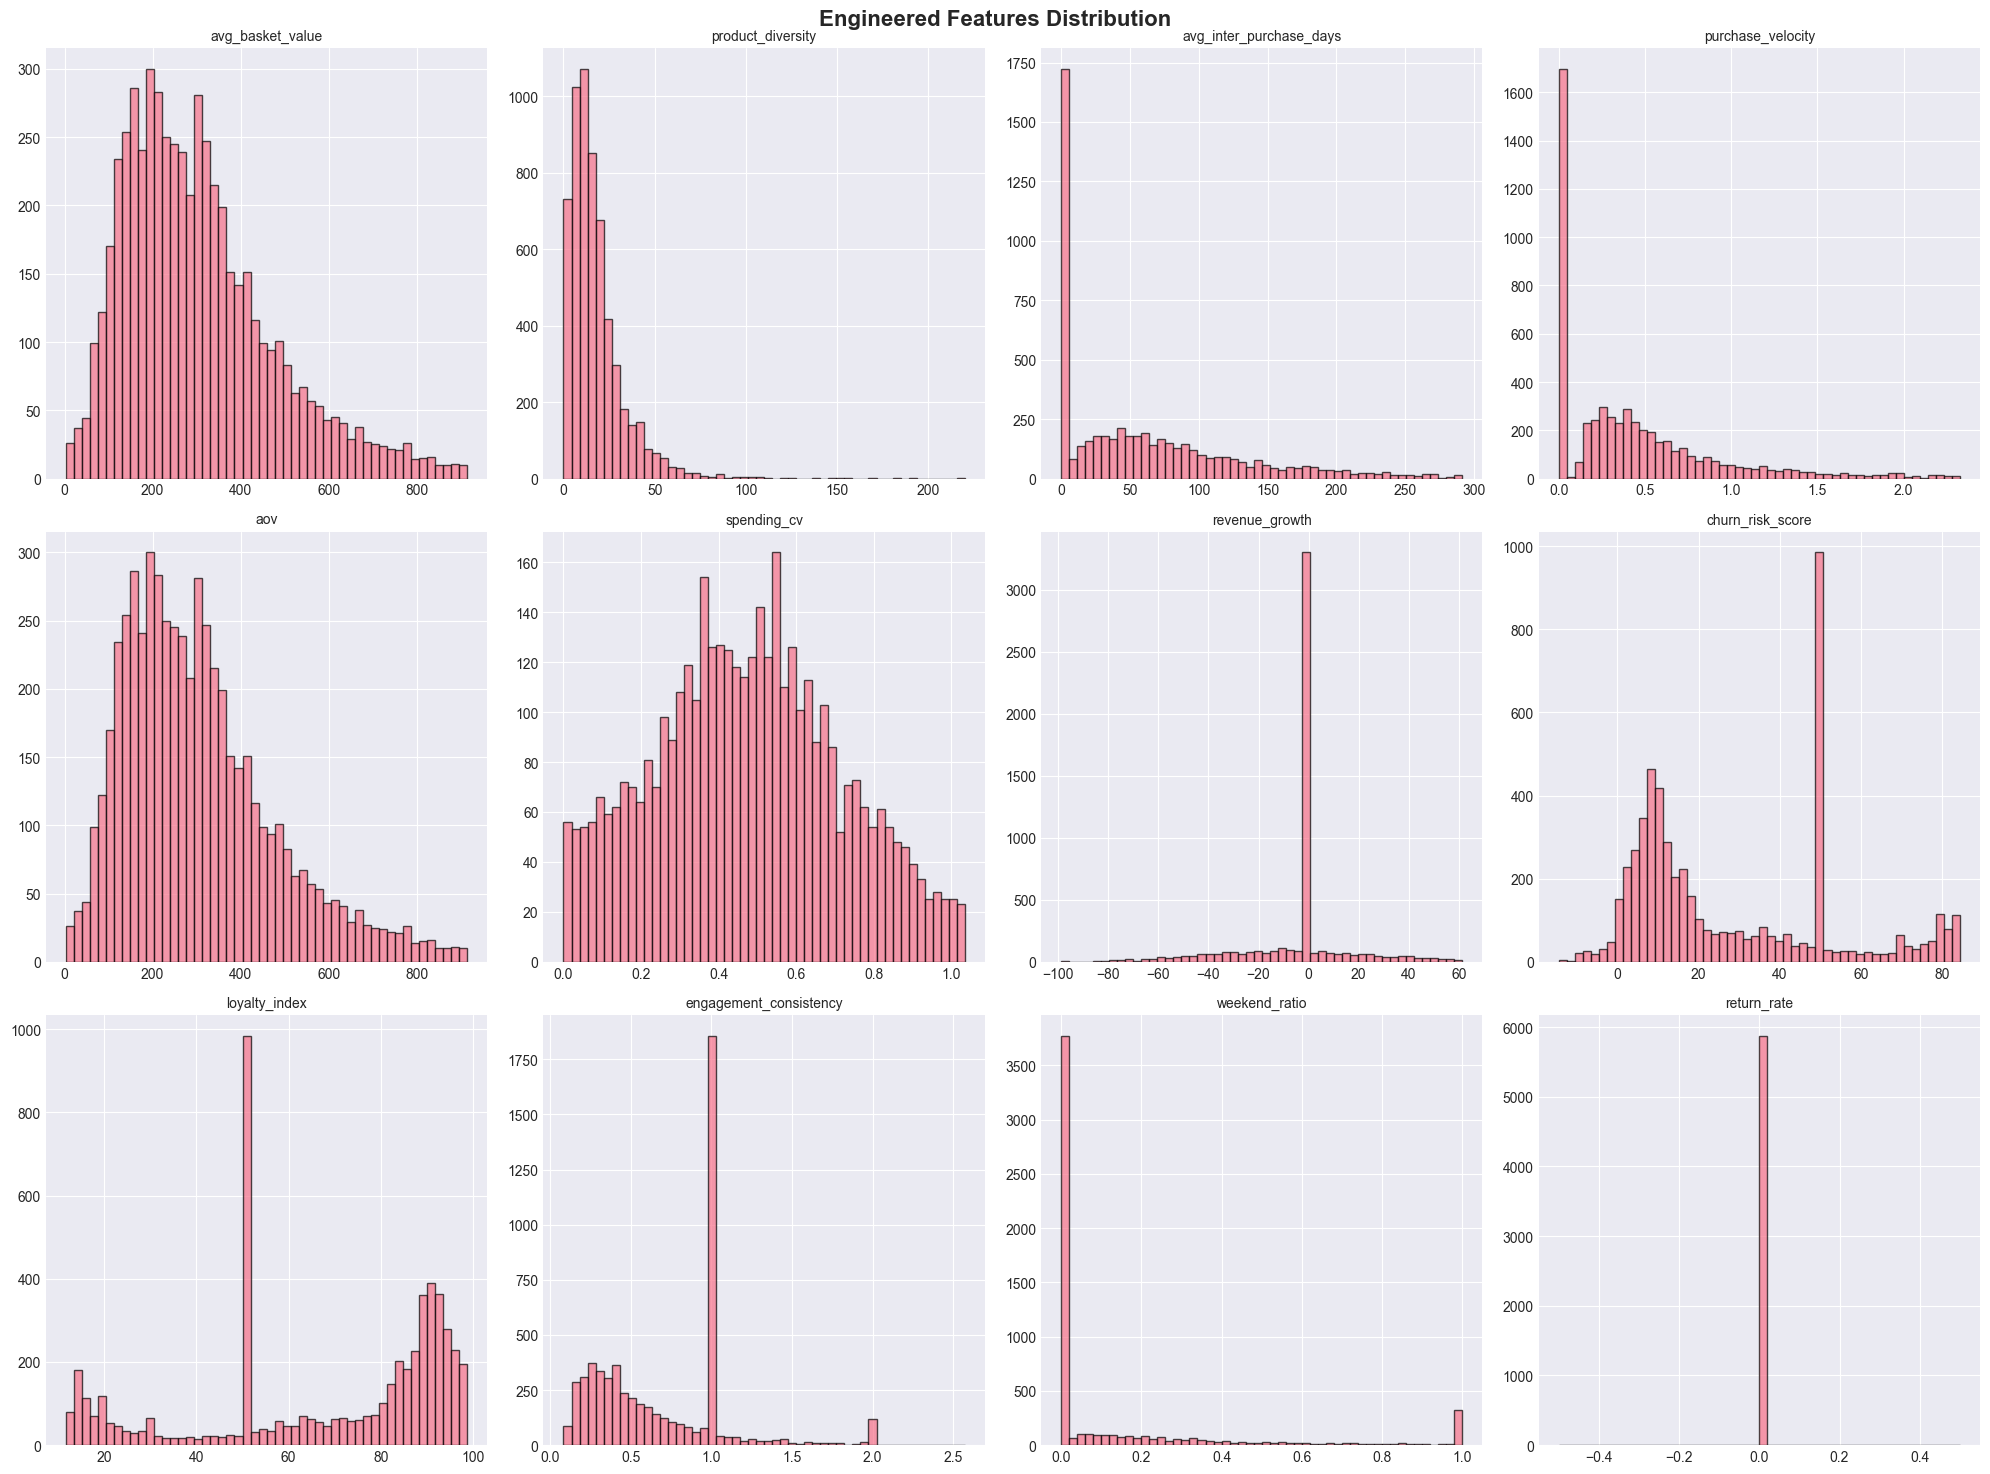

In [8]:
# Key features distribution
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Engineered Features Distribution', fontsize=16, fontweight='bold')
axes = axes.flatten()

key_features = [
    'avg_basket_value', 'product_diversity', 'avg_inter_purchase_days',
    'purchase_velocity', 'aov', 'spending_cv', 'revenue_growth',
    'churn_risk_score', 'loyalty_index', 'engagement_consistency',
    'weekend_ratio', 'return_rate'
]

for idx, feature in enumerate(key_features):
    # Remove outliers for visualization (keep 95th percentile)
    data_to_plot = features_master[feature]
    if feature not in ['weekend_ratio', 'return_rate', 'engagement_consistency', 'product_diversity']:
        q95 = data_to_plot.quantile(0.95)
        data_to_plot = data_to_plot[data_to_plot <= q95]
    
    data_to_plot.hist(bins=50, ax=axes[idx], edgecolor='black', alpha=0.7)
    axes[idx].set_title(feature, fontsize=10)
    axes[idx].set_xlabel('')

plt.tight_layout()
plt.show()

## 7. **Feature Correlation Analysis**

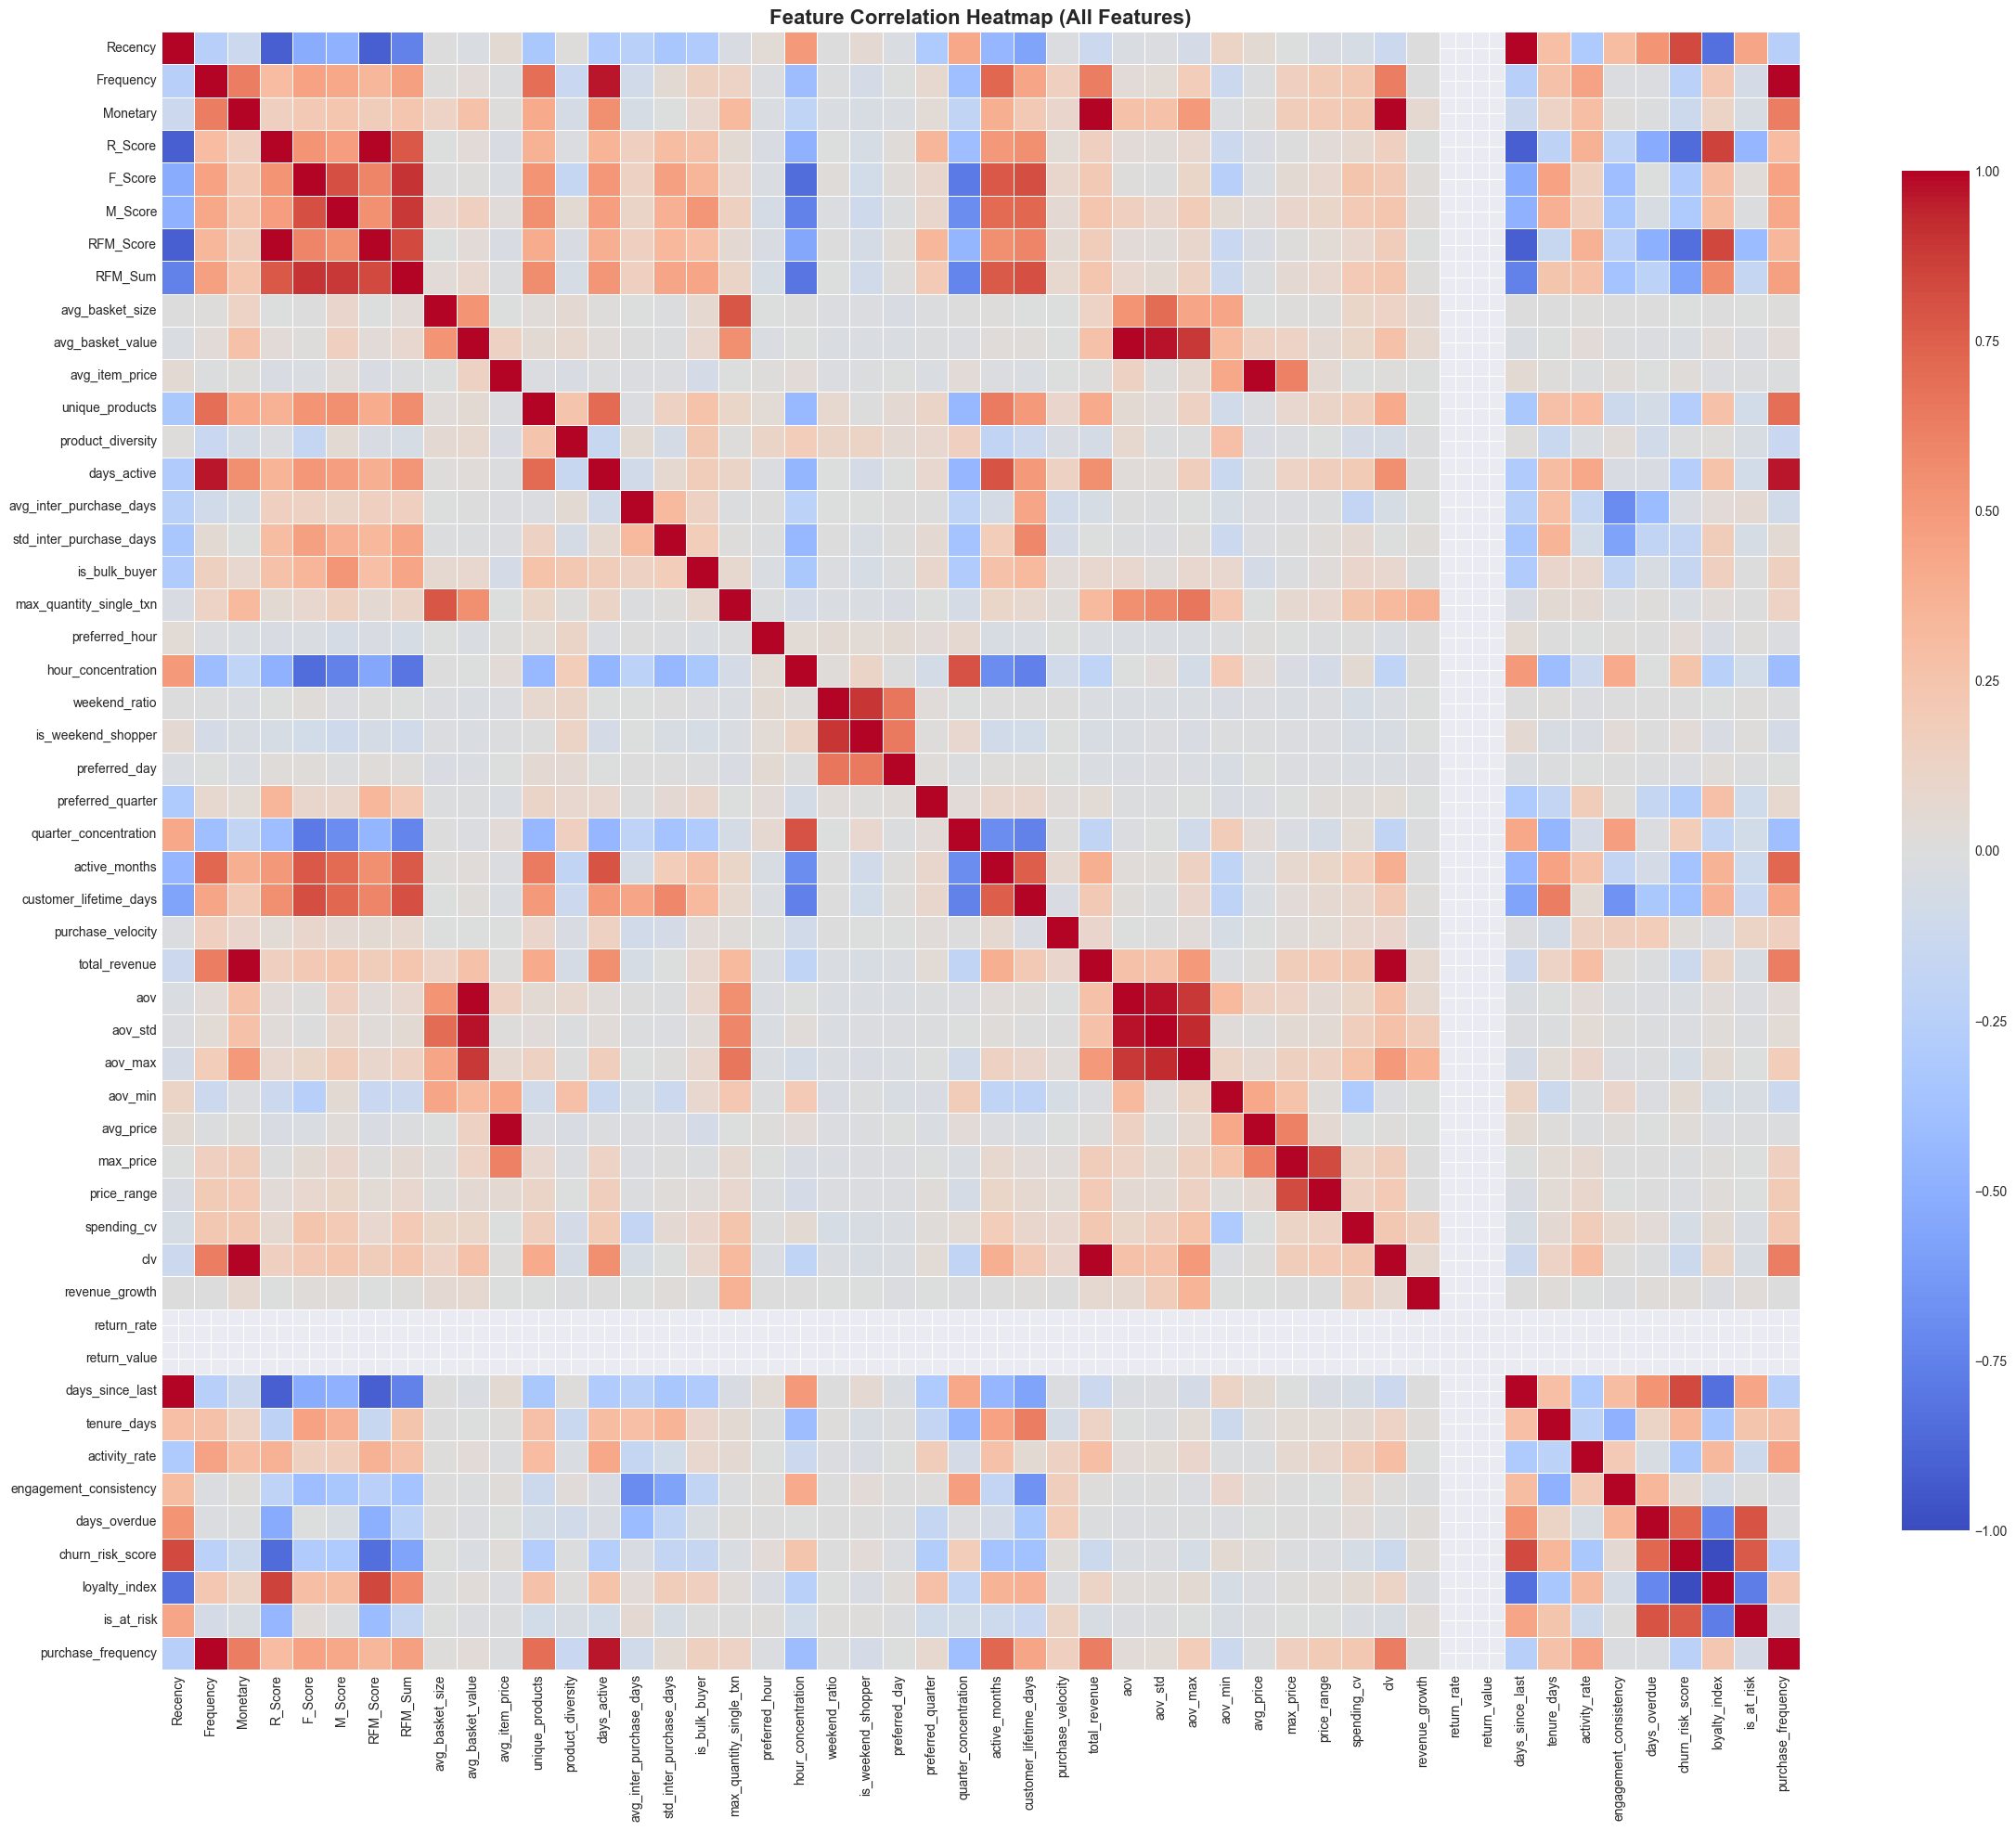


⚠️  Highly Correlated Features (|r| > 0.8):
       Feature 1              Feature 2  Correlation
         Recency        days_since_last         1.00
  avg_item_price              avg_price         1.00
avg_basket_value                    aov         1.00
        Monetary                    clv         1.00
        Monetary          total_revenue         1.00
       Frequency     purchase_frequency         1.00
   total_revenue                    clv         1.00
churn_risk_score          loyalty_index        -1.00
         R_Score              RFM_Score         1.00
             aov                aov_std         0.97
avg_basket_value                aov_std         0.97
       Frequency            days_active         0.97
     days_active     purchase_frequency         0.97
         aov_std                aov_max         0.92
         Recency              RFM_Score        -0.91
       RFM_Score        days_since_last        -0.91
         Recency                R_Score        -0.91
 

In [9]:
# Select numeric features for correlation
numeric_features = features_master.select_dtypes(include=[np.number]).drop(['CustomerID'], axis=1, errors='ignore')

# Correlation matrix
corr_matrix = numeric_features.corr()

# Heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (All Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print("\n⚠️  Highly Correlated Features (|r| > 0.8):")
    print(high_corr_df.to_string(index=False))
    print("\n💡 Consider removing one feature from each pair for clustering to reduce multicollinearity")
else:
    print("\n✅ No highly correlated features (|r| > 0.8) found")

## 8. **Segment-Level Analysis**

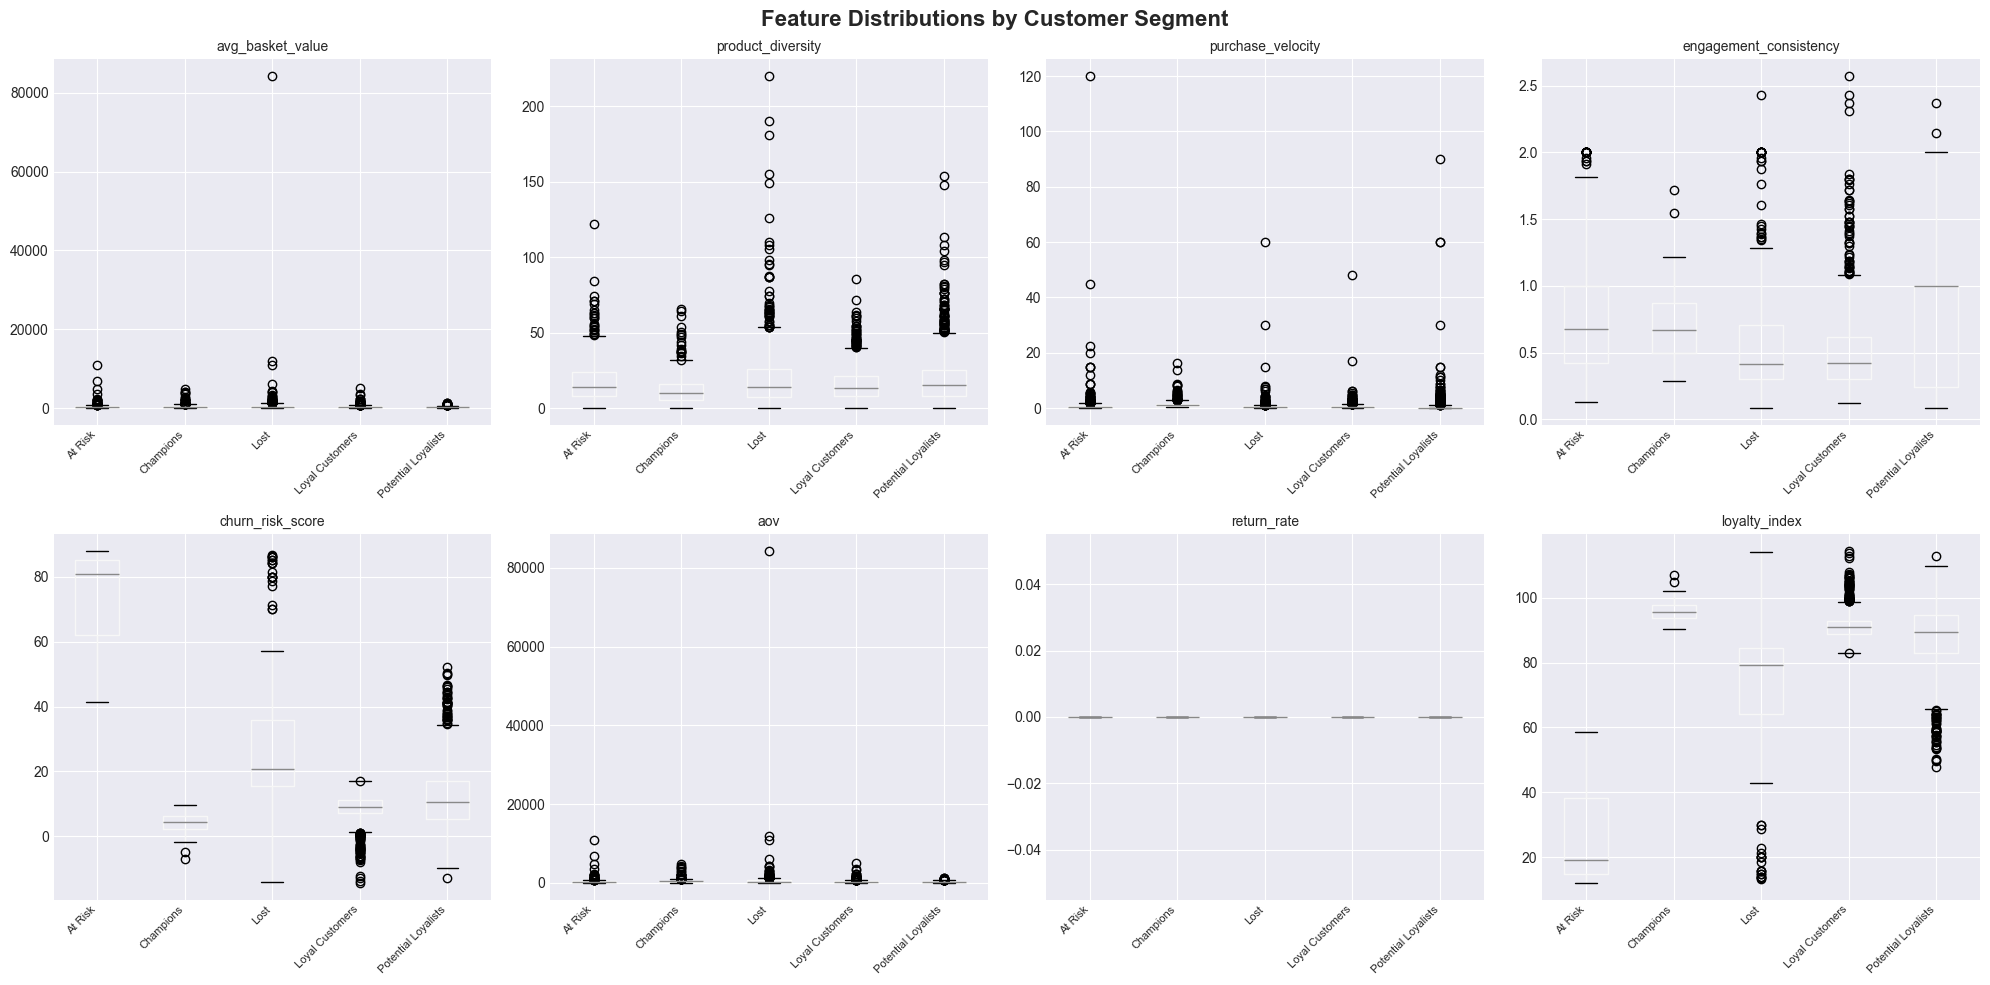


📊 Average Feature Values by Segment:
                     avg_basket_value  product_diversity  purchase_velocity  \
Segment                                                                       
At Risk                        397.63              18.29               1.30   
Champions                      518.29              12.37               1.36   
Lost                           640.00              20.41               0.70   
Loyal Customers                382.46              16.11               0.77   
Potential Loyalists            274.35              19.49               0.77   

                     engagement_consistency  churn_risk_score    aov  \
Segment                                                                
At Risk                                0.76             73.74 397.63   
Champions                              0.69              4.18 518.29   
Lost                                   0.54             25.70 640.00   
Loyal Customers                        0.51     

In [10]:
# Compare features across key segments
key_segments = ['Champions', 'Loyal Customers', 'At Risk', 'Lost', 'Potential Loyalists']
segment_data = features_master[features_master['Segment'].isin(key_segments)]

comparison_features = [
    'avg_basket_value', 'product_diversity', 'purchase_velocity',
    'engagement_consistency', 'churn_risk_score', 'aov', 'return_rate', 'loyalty_index'
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Feature Distributions by Customer Segment', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(comparison_features):
    segment_data.boxplot(column=feature, by='Segment', ax=axes[idx])
    axes[idx].set_title(feature, fontsize=10)
    axes[idx].set_xlabel('')
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

plt.suptitle('Feature Distributions by Customer Segment', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Segment averages
segment_profiles = segment_data.groupby('Segment')[comparison_features].mean()
print("\n📊 Average Feature Values by Segment:")
print(segment_profiles.round(2))

## 9. **Save Master Feature Set**

In [11]:
# Save to CSV
features_master.to_csv(path_features + 'features_master.csv', index=False)

print(f"✅ Master feature set saved to: {path_features}features_master.csv")
print(f"\n📊 Final Dataset Summary:")
print(f"  - Total Customers: {len(features_master):,}")
print(f"  - Total Features: {len(features_master.columns)}")
print(f"  - RFM Base: 10 columns")
print(f"  - Engineered Features: 42 columns")
print(f"  - Storage Size: {features_master.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Master feature set saved to: /home/cairo/code/portfolio/customer-segmentation/data/features/features_master.csv

📊 Final Dataset Summary:
  - Total Customers: 5,878
  - Total Features: 52
  - RFM Base: 10 columns
  - Engineered Features: 42 columns
  - Storage Size: 2.33 MB


## 10. **Key Business Insights**

In [12]:
# Generate automated insights
print("🎯 KEY BUSINESS INSIGHTS FROM FEATURE ENGINEERING")
print("=" * 100)

# 1. Churn Risk
high_risk = features_master[features_master['churn_risk_score'] > 60]
high_risk_revenue = high_risk['Monetary'].sum()
total_revenue = features_master['Monetary'].sum()
print(f"\n1. CHURN RISK ALERT")
print(f"   📊 {len(high_risk):,} customers ({len(high_risk)/len(features_master)*100:.1f}%) at high risk")
print(f"   💰 £{high_risk_revenue:,.0f} in revenue at risk ({high_risk_revenue/total_revenue*100:.1f}% of total)")
print(f"   💡 Priority: Immediate reactivation campaigns")

# 2. Bulk Buyers
bulk_buyers = features_master[features_master['is_bulk_buyer'] == 1]
bulk_aov = bulk_buyers['aov'].mean()
regular_aov = features_master[features_master['is_bulk_buyer'] == 0]['aov'].mean()
print(f"\n2. BULK BUYER OPPORTUNITY")
print(f"   📊 {len(bulk_buyers):,} bulk buyers identified")
print(f"   💰 AOV: £{bulk_aov:,.0f} vs £{regular_aov:,.0f} ({(bulk_aov/regular_aov-1)*100:.0f}% higher)")
print(f"   💡 Strategy: B2B tier with volume discounts")

# 3. Low Product Diversity
low_diversity = features_master[features_master['product_diversity'] < 2]
print(f"\n3. CROSS-SELL OPPORTUNITY")
print(f"   📊 {len(low_diversity):,} customers buy <2 products per order")
print(f"   💰 £{low_diversity['Monetary'].sum():,.0f} revenue from low-diversity customers")
print(f"   💡 Action: Product recommendations & bundles")

# 4. Revenue Growth
growing = features_master[features_master['revenue_growth'] > 20]
print(f"\n4. GROWTH SEGMENT")
print(f"   📊 {len(growing):,} customers show >20% revenue growth")
print(f"   💰 Average growth: {growing['revenue_growth'].mean():.1f}%")
print(f"   💡 Nurture: Loyalty programs & VIP status")

# 5. Weekend Shoppers
weekend = features_master[features_master['is_weekend_shopper'] == 1]
print(f"\n5. WEEKEND SHOPPING PATTERN")
print(f"   📊 {len(weekend):,} weekend-preferred customers")
print(f"   💰 Weekend AOV: £{weekend['aov'].mean():,.0f}")
print(f"   💡 Timing: Weekend-exclusive promotions")

print("\n" + "=" * 100)

🎯 KEY BUSINESS INSIGHTS FROM FEATURE ENGINEERING

1. CHURN RISK ALERT
   📊 917 customers (15.6%) at high risk
   💰 £1,515,933 in revenue at risk (8.5% of total)
   💡 Priority: Immediate reactivation campaigns

2. BULK BUYER OPPORTUNITY
   📊 4,796 bulk buyers identified
   💰 AOV: £440 vs £179 (145% higher)
   💡 Strategy: B2B tier with volume discounts

3. CROSS-SELL OPPORTUNITY
   📊 291 customers buy <2 products per order
   💰 £2,075,569 revenue from low-diversity customers
   💡 Action: Product recommendations & bundles

4. GROWTH SEGMENT
   📊 800 customers show >20% revenue growth
   💰 Average growth: 139.7%
   💡 Nurture: Loyalty programs & VIP status

5. WEEKEND SHOPPING PATTERN
   📊 652 weekend-preferred customers
   💰 Weekend AOV: £297
   💡 Timing: Weekend-exclusive promotions



Complete! :)